## SIMMAN2008，只有Res+attention，模型表现测试

[I 2025-03-21 15:42:43,074] A new study created in memory with name: no-name-2b38baa4-44d6-4abd-a2e0-23937d645cfd
[I 2025-03-21 15:43:39,881] Trial 0 finished with value: 0.00819737371057272 and parameters: {'lr': 0.00999357267157358, 'weight_decay': 0.00020974368822853384, 'dropout_rate': 0.27680087794332214, 'hidden_size': 256, 'beta': 0.37875727514065904}. Best is trial 0 with value: 0.00819737371057272.
[I 2025-03-21 15:44:23,257] Trial 1 finished with value: 0.0067503429017961025 and parameters: {'lr': 0.0008452154231784761, 'weight_decay': 2.4479112948565998e-05, 'dropout_rate': 0.3992805970093025, 'hidden_size': 128, 'beta': 0.85390846763328}. Best is trial 1 with value: 0.0067503429017961025.
[I 2025-03-21 15:45:37,571] Trial 2 finished with value: 0.002465683501213789 and parameters: {'lr': 0.0055635014999222965, 'weight_decay': 6.167871178563368e-06, 'dropout_rate': 0.32643306212300627, 'hidden_size': 512, 'beta': 0.7297188309483175}. Best is trial 2 with value: 0.00246568350

Best trial:
  Value: 0.001580159063450992
  Params: 
    lr: 0.007475897068878416
    weight_decay: 7.026907938109881e-05
    dropout_rate: 0.21058148904830643
    hidden_size: 512
    beta: 0.9827595512162322
Epoch [40/200], Loss: 0.00129243
Epoch [80/200], Loss: 0.00069851
Epoch [120/200], Loss: 0.00072555
Epoch [160/200], Loss: 0.00059168
Epoch [200/200], Loss: 0.00050006
训练完成，下面生成可视化样图：


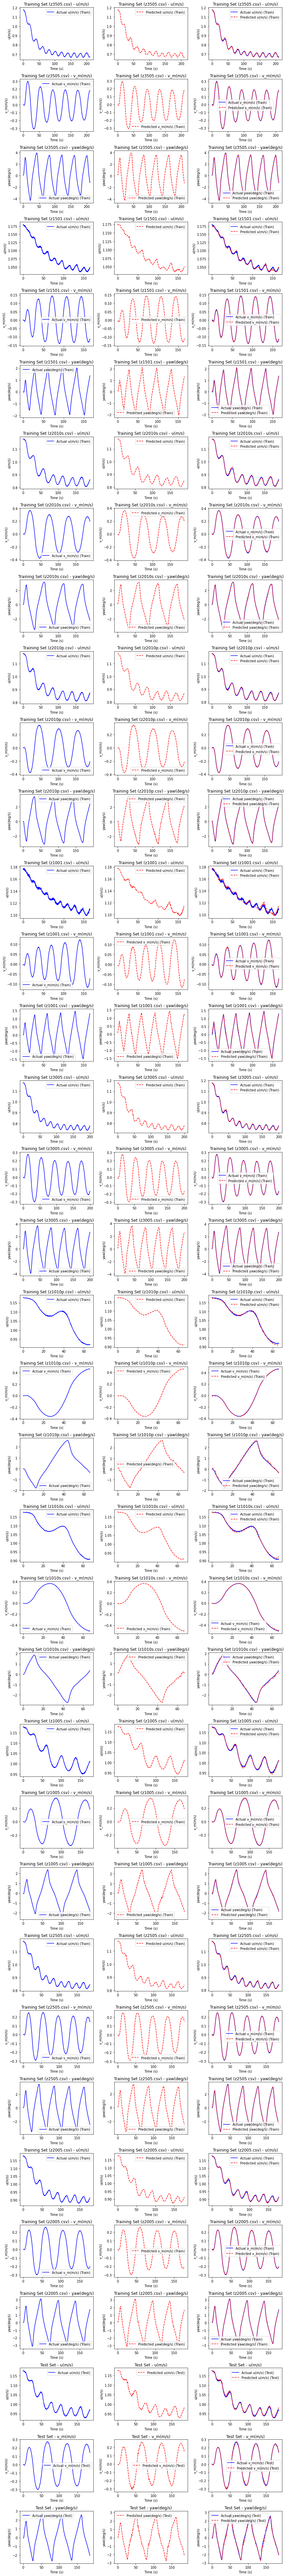

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 读取SIMMAN2020文件夹下的所有CSV文件（排除MARIN_FREE_KVLCC2_zz_-10_m.csv作为测试集）
folder_path = 'SIMMAN2008_backup'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f != 'z1505.csv']
# 加载训练数据
inputs_train_list = []
targets_train_list = []
time_train_list = []  # 存储每个训练集的时间序列
for file in file_list:
    data = pd.read_csv(os.path.join(folder_path, file))
    inputs = data[['x', 'y', 'time', 'psi','p', 'delta', 'n']].values
    targets = data[['u', 'v', 'r']].values
    time_train = data['time'].values  # 获取时间序列
    inputs_train_list.append(inputs)
    targets_train_list.append(targets)
    time_train_list.append(time_train)

# 合并训练数据
inputs_train = np.vstack(inputs_train_list)
targets_train = np.vstack(targets_train_list)

# 加载测试数据
test_data = pd.read_csv(os.path.join(folder_path, 'z1505.csv'))
inputs_test = test_data[['x', 'y', 'time', 'psi','p', 'delta', 'n']].values
targets_test = test_data[['u', 'v', 'r']].values
time_test = test_data['time'].values  # 测试集的时间序列

# 对输入进行标准化
input_scaler = StandardScaler()
inputs_train = input_scaler.fit_transform(inputs_train)
inputs_test = input_scaler.transform(inputs_test)

# 对目标（输出）进行标准化
target_scaler = StandardScaler()
targets_train = target_scaler.fit_transform(targets_train)
targets_test = target_scaler.transform(targets_test)

# 转换为 PyTorch 张量
X_train = torch.tensor(inputs_train, dtype=torch.float32)
y_train = torch.tensor(targets_train, dtype=torch.float32)
X_test = torch.tensor(inputs_test, dtype=torch.float32)
y_test = torch.tensor(targets_test, dtype=torch.float32)

# 创建 DataLoader，用于批量训练
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # 设定合适的批量大小

# 修改 ResidualAttentionNN 类以接受超参数
class ResidualAttentionNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=512, dropout_rate=0.3, num_heads=4):
        super(ResidualAttentionNN, self).__init__()
        
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.SiLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LayerNorm(hidden_size // 4),
            nn.SiLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )

        self.residual_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size // 16, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(hidden_size // 16, 3)

    def forward(self, x):
        base_out = self.base(x)
        residual = self.residual_layer(x)
        combined = base_out + residual
        attn_out, _ = self.attention(combined.unsqueeze(1), combined.unsqueeze(1), combined.unsqueeze(1))
        attn_out = attn_out.squeeze(1)
        combined = combined + attn_out
        return self.output_layer(combined)

# 定义 Optuna 目标函数 - 使用测试集而不是验证集
def objective(trial):
    # 超参数搜索空间
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    num_heads = 4
    beta = trial.suggest_float('beta', 0.1, 1.0)

    # 定义模型
    model = ResidualAttentionNN(input_size=7, hidden_size=hidden_size, dropout_rate=dropout_rate, num_heads=num_heads)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=beta)

    # 训练模型
    epochs = 30  # 为了快速调优，减少 epoch 数量
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 测试集评估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)

        # 报告中间结果
        trial.report(test_loss.item(), epoch)

        # 提前停止
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return test_loss.item()

# 创建 Optuna 学习并优化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# 输出最佳超参数
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# 使用最佳超参数训练最终模型
best_params = trial.params
model = ResidualAttentionNN(input_size=7, hidden_size=best_params['hidden_size'], dropout_rate=best_params['dropout_rate'], num_heads=4)
optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.SmoothL1Loss(beta=best_params['beta'])

# 训练最终模型
epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 40 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.8f}')

# 预测并反归一化
model.eval()
with torch.no_grad():
    y_train_pred_list = []
    for inputs in inputs_train_list:
        inputs_scaled = input_scaler.transform(inputs)
        inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)
        y_train_pred = model(inputs_tensor).numpy()
        y_train_pred = target_scaler.inverse_transform(y_train_pred)
        y_train_pred_list.append(y_train_pred)

    y_test_pred = model(X_test).numpy()
    y_test_pred = target_scaler.inverse_transform(y_test_pred)

# 反归一化实际值
targets_train_list_original = []
for targets in targets_train_list:
    targets_original = target_scaler.inverse_transform(
        target_scaler.transform(targets))  # 确保格式一致
    targets_train_list_original.append(targets_original)

targets_test_original = target_scaler.inverse_transform(targets_test)

print("训练完成，下面生成可视化样图：")

# `variables` 存储要绘制的目标变量名称
variables = ['u(m/s)', 'v_m(m/s)', 'yaw(deg/s)']

# 计算总行数，每个变量单独绘制
num_rows = 3 * (len(file_list) + 1)  # 每个文件3个变量，加上测试集

# 创建子图：每个变量单独呈现
fig, axs = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))

# 训练集绘图
for idx, (file, y_train_pred, targets_train, time_train) in enumerate(zip(file_list, y_train_pred_list, targets_train_list_original, time_train_list)):
    for i in range(3):  # 每个变量单独绘制（只有3个输出变量）
        row = idx * 3 + i  # 计算当前变量的行索引
        axs[row, 0].plot(time_train, targets_train[:, i], 'b-', label=f'Actual {variables[i]} (Train)')  # 第一列：实际值
        axs[row, 1].plot(time_train, y_train_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Train)')  # 第二列：预测值
        axs[row, 2].plot(time_train, targets_train[:, i], 'b-', label=f'Actual {variables[i]} (Train)')  # 第三列：对比
        axs[row, 2].plot(time_train, y_train_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Train)')  # 第三列：对比
        axs[row, 0].set_title(f'Training Set ({file}) - {variables[i]}')
        axs[row, 1].set_title(f'Training Set ({file}) - {variables[i]}')
        axs[row, 2].set_title(f'Training Set ({file}) - {variables[i]}')

# 测试集绘图
for i in range(3):  # 每个变量单独绘制（只有3个输出变量）
    row = len(file_list) * 3 + i
    axs[row, 0].plot(time_test, targets_test_original[:, i], 'b-', label=f'Actual {variables[i]} (Test)')  # 第一列：实际值
    axs[row, 1].plot(time_test, y_test_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Test)')  # 第二列：预测值
    axs[row, 2].plot(time_test, targets_test_original[:, i], 'b-', label=f'Actual {variables[i]} (Test)')  # 第三列：对比
    axs[row, 2].plot(time_test, y_test_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Test)')  # 第三列：对比
    axs[row, 0].set_title(f'Test Set - {variables[i]}')
    axs[row, 1].set_title(f'Test Set - {variables[i]}')
    axs[row, 2].set_title(f'Test Set - {variables[i]}')

# 统一设置X轴标签
for ax in axs.flat:
    ax.set_xlabel('Time (s)')

# 统一设置Y轴标签
for i in range(num_rows):
    variable_idx = i % 3  # 使用模3获取变量索引，避免超出范围
    axs[i, 0].set_ylabel(variables[variable_idx])
    axs[i, 1].set_ylabel(variables[variable_idx])
    axs[i, 2].set_ylabel(variables[variable_idx])

# 添加图例
for i in range(num_rows):
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 2].legend()

plt.tight_layout()
plt.show()

##  SIMMAN2008，只有Res+Attention，泛化能力测试

[I 2025-04-12 22:41:28,866] A new study created in memory with name: no-name-05fbe0aa-acfb-4b5e-8f30-769c55d685ac
[I 2025-04-12 22:42:01,653] Trial 0 finished with value: 0.15713049471378326 and parameters: {'lr': 0.00028018890564634314, 'weight_decay': 2.0360273676060008e-06, 'dropout_rate': 0.37346061609921727, 'hidden_size': 512, 'beta': 0.4637098629011178}. Best is trial 0 with value: 0.15713049471378326.
[I 2025-04-12 22:42:33,686] Trial 1 finished with value: 0.0667073056101799 and parameters: {'lr': 4.841198373800901e-05, 'weight_decay': 3.2328221161470105e-05, 'dropout_rate': 0.21088292145249513, 'hidden_size': 512, 'beta': 0.8703066350372421}. Best is trial 1 with value: 0.0667073056101799.
[I 2025-04-12 22:43:05,725] Trial 2 finished with value: 0.12503491342067719 and parameters: {'lr': 5.568975932093376e-05, 'weight_decay': 3.6616942350295474e-06, 'dropout_rate': 0.47714794154174794, 'hidden_size': 512, 'beta': 0.5412864403583628}. Best is trial 1 with value: 0.066707305610

Best trial:
  Value: 0.0667073056101799
  Params: 
    lr: 4.841198373800901e-05
    weight_decay: 3.2328221161470105e-05
    dropout_rate: 0.21088292145249513
    hidden_size: 512
    beta: 0.8703066350372421
Epoch [40/200], Loss: 0.01129732
Epoch [80/200], Loss: 0.00644357
Epoch [120/200], Loss: 0.00401240
Epoch [160/200], Loss: 0.00295487
Epoch [200/200], Loss: 0.00238094
训练完成，下面生成可视化样图：


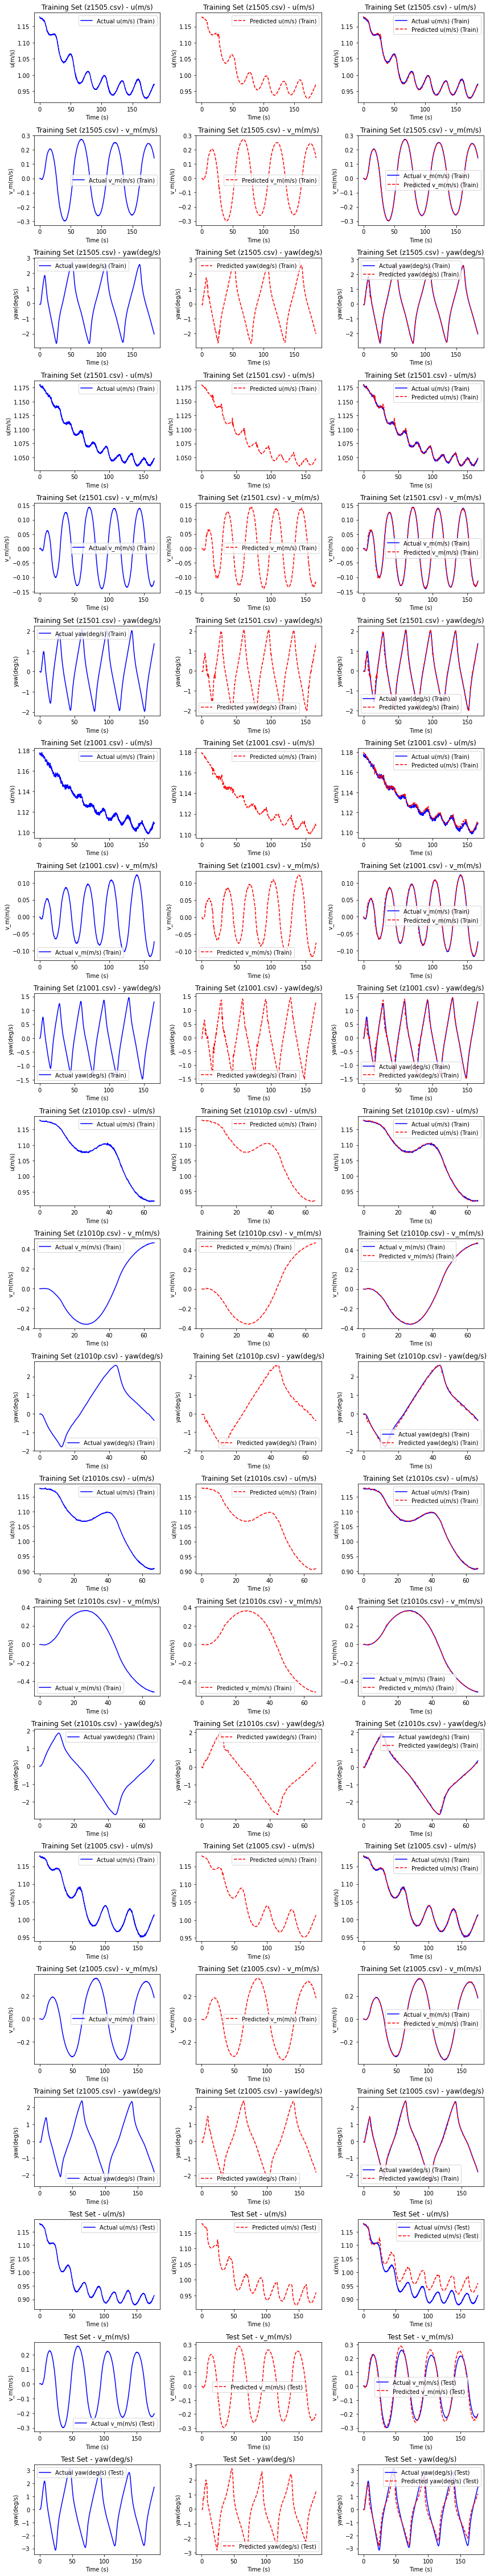

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 读取SIMMAN2020文件夹下的所有CSV文件（排除MARIN_FREE_KVLCC2_zz_-10_m.csv作为测试集）
folder_path = 'SIMMAN2008'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f != 'z2005.csv']
# 加载训练数据
inputs_train_list = []
targets_train_list = []
time_train_list = []  # 存储每个训练集的时间序列
for file in file_list:
    data = pd.read_csv(os.path.join(folder_path, file))
    inputs = data[['x', 'y', 'time', 'psi','p', 'delta', 'n']].values
    targets = data[['u', 'v', 'r']].values
    time_train = data['time'].values  # 获取时间序列
    inputs_train_list.append(inputs)
    targets_train_list.append(targets)
    time_train_list.append(time_train)

# 合并训练数据
inputs_train = np.vstack(inputs_train_list)
targets_train = np.vstack(targets_train_list)

# 加载测试数据
test_data = pd.read_csv(os.path.join(folder_path, 'z2005.csv'))
inputs_test = test_data[['x', 'y', 'time', 'psi','p', 'delta', 'n']].values
targets_test = test_data[['u', 'v', 'r']].values
time_test = test_data['time'].values  # 测试集的时间序列

# 对输入进行标准化
input_scaler = StandardScaler()
inputs_train = input_scaler.fit_transform(inputs_train)
inputs_test = input_scaler.transform(inputs_test)

# 对目标（输出）进行标准化
target_scaler = StandardScaler()
targets_train = target_scaler.fit_transform(targets_train)
targets_test = target_scaler.transform(targets_test)

# 转换为 PyTorch 张量
X_train = torch.tensor(inputs_train, dtype=torch.float32)
y_train = torch.tensor(targets_train, dtype=torch.float32)
X_test = torch.tensor(inputs_test, dtype=torch.float32)
y_test = torch.tensor(targets_test, dtype=torch.float32)

# 创建 DataLoader，用于批量训练
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # 设定合适的批量大小

# 修改 ResidualAttentionNN 类以接受超参数
class ResidualAttentionNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=512, dropout_rate=0.3, num_heads=4):
        super(ResidualAttentionNN, self).__init__()
        
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.SiLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LayerNorm(hidden_size // 4),
            nn.SiLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )

        self.residual_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size // 16, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(hidden_size // 16, 3)

    def forward(self, x):
        base_out = self.base(x)
        residual = self.residual_layer(x)
        combined = base_out + residual
        attn_out, _ = self.attention(combined.unsqueeze(1), combined.unsqueeze(1), combined.unsqueeze(1))
        attn_out = attn_out.squeeze(1)
        combined = combined + attn_out
        return self.output_layer(combined)

# 定义 Optuna 目标函数 - 使用测试集而不是验证集
def objective(trial):
    # 超参数搜索空间
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    num_heads = 4
    beta = trial.suggest_float('beta', 0.1, 1.0)

    # 定义模型
    model = ResidualAttentionNN(input_size=7, hidden_size=hidden_size, dropout_rate=dropout_rate, num_heads=num_heads)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=beta)

    # 训练模型
    epochs = 30  # 为了快速调优，减少 epoch 数量
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 测试集评估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)

        # 报告中间结果
        trial.report(test_loss.item(), epoch)

        # 提前停止
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return test_loss.item()

# 创建 Optuna 学习并优化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 输出最佳超参数
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# 使用最佳超参数训练最终模型
best_params = trial.params
model = ResidualAttentionNN(input_size=7, hidden_size=best_params['hidden_size'], dropout_rate=best_params['dropout_rate'], num_heads=4)
optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.SmoothL1Loss(beta=best_params['beta'])

# 训练最终模型
epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 40 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.8f}')

# 预测并反归一化
model.eval()
with torch.no_grad():
    y_train_pred_list = []
    for inputs in inputs_train_list:
        inputs_scaled = input_scaler.transform(inputs)
        inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)
        y_train_pred = model(inputs_tensor).numpy()
        y_train_pred = target_scaler.inverse_transform(y_train_pred)
        y_train_pred_list.append(y_train_pred)

    y_test_pred = model(X_test).numpy()
    y_test_pred = target_scaler.inverse_transform(y_test_pred)

# 反归一化实际值
targets_train_list_original = []
for targets in targets_train_list:
    targets_original = target_scaler.inverse_transform(
        target_scaler.transform(targets))  # 确保格式一致
    targets_train_list_original.append(targets_original)

targets_test_original = target_scaler.inverse_transform(targets_test)

print("训练完成，下面生成可视化样图：")

# `variables` 存储要绘制的目标变量名称
variables = ['u(m/s)', 'v_m(m/s)', 'yaw(deg/s)']

# 计算总行数，每个变量单独绘制
num_rows = 3 * (len(file_list) + 1)  # 每个文件3个变量，加上测试集

# 创建子图：每个变量单独呈现
fig, axs = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))

# 训练集绘图
for idx, (file, y_train_pred, targets_train, time_train) in enumerate(zip(file_list, y_train_pred_list, targets_train_list_original, time_train_list)):
    for i in range(3):  # 每个变量单独绘制（只有3个输出变量）
        row = idx * 3 + i  # 计算当前变量的行索引
        axs[row, 0].plot(time_train, targets_train[:, i], 'b-', label=f'Actual {variables[i]} (Train)')  # 第一列：实际值
        axs[row, 1].plot(time_train, y_train_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Train)')  # 第二列：预测值
        axs[row, 2].plot(time_train, targets_train[:, i], 'b-', label=f'Actual {variables[i]} (Train)')  # 第三列：对比
        axs[row, 2].plot(time_train, y_train_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Train)')  # 第三列：对比
        axs[row, 0].set_title(f'Training Set ({file}) - {variables[i]}')
        axs[row, 1].set_title(f'Training Set ({file}) - {variables[i]}')
        axs[row, 2].set_title(f'Training Set ({file}) - {variables[i]}')

# 测试集绘图
for i in range(3):  # 每个变量单独绘制（只有3个输出变量）
    row = len(file_list) * 3 + i
    axs[row, 0].plot(time_test, targets_test_original[:, i], 'b-', label=f'Actual {variables[i]} (Test)')  # 第一列：实际值
    axs[row, 1].plot(time_test, y_test_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Test)')  # 第二列：预测值
    axs[row, 2].plot(time_test, targets_test_original[:, i], 'b-', label=f'Actual {variables[i]} (Test)')  # 第三列：对比
    axs[row, 2].plot(time_test, y_test_pred[:, i], 'r--', label=f'Predicted {variables[i]} (Test)')  # 第三列：对比
    axs[row, 0].set_title(f'Test Set - {variables[i]}')
    axs[row, 1].set_title(f'Test Set - {variables[i]}')
    axs[row, 2].set_title(f'Test Set - {variables[i]}')

# 统一设置X轴标签
for ax in axs.flat:
    ax.set_xlabel('Time (s)')

# 统一设置Y轴标签
for i in range(num_rows):
    variable_idx = i % 3  # 使用模3获取变量索引，避免超出范围
    axs[i, 0].set_ylabel(variables[variable_idx])
    axs[i, 1].set_ylabel(variables[variable_idx])
    axs[i, 2].set_ylabel(variables[variable_idx])

# 添加图例
for i in range(num_rows):
    axs[i, 0].legend()
    axs[i, 1].legend()
    axs[i, 2].legend()

plt.tight_layout()
plt.show()